In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from skimage.transform import iradon, radon

from racts_utils import create_dobj, insert_dobj, sample_sino

# Load in data

In [3]:
path = "/work/bel25/datasets/ground_truth_train_136.hdf5"
f = h5py.File(path, 'r')
raw_img = f['data'][0]

# With fake data

In [5]:
[1/32, 1/16, 1/8, 1/4, 1/2]

[0.03125, 0.0625, 0.125, 0.25, 0.5]

target sample rate: 0.10, effective sample rate: 0.10
[ 0 10 20 30 40 50 60 70 80 90]
target sample rate: 0.20, effective sample rate: 0.20
[ 0  5 10 15 20 25 30 35 40 45]
target sample rate: 0.30, effective sample rate: 0.30
[ 0  3  6 10 13 16 20 23 26 30]
target sample rate: 0.40, effective sample rate: 0.40
[ 0  2  5  7 10 12 15 17 20 22]
target sample rate: 0.50, effective sample rate: 0.50
[ 0  2  4  6  8 10 12 14 16 18]


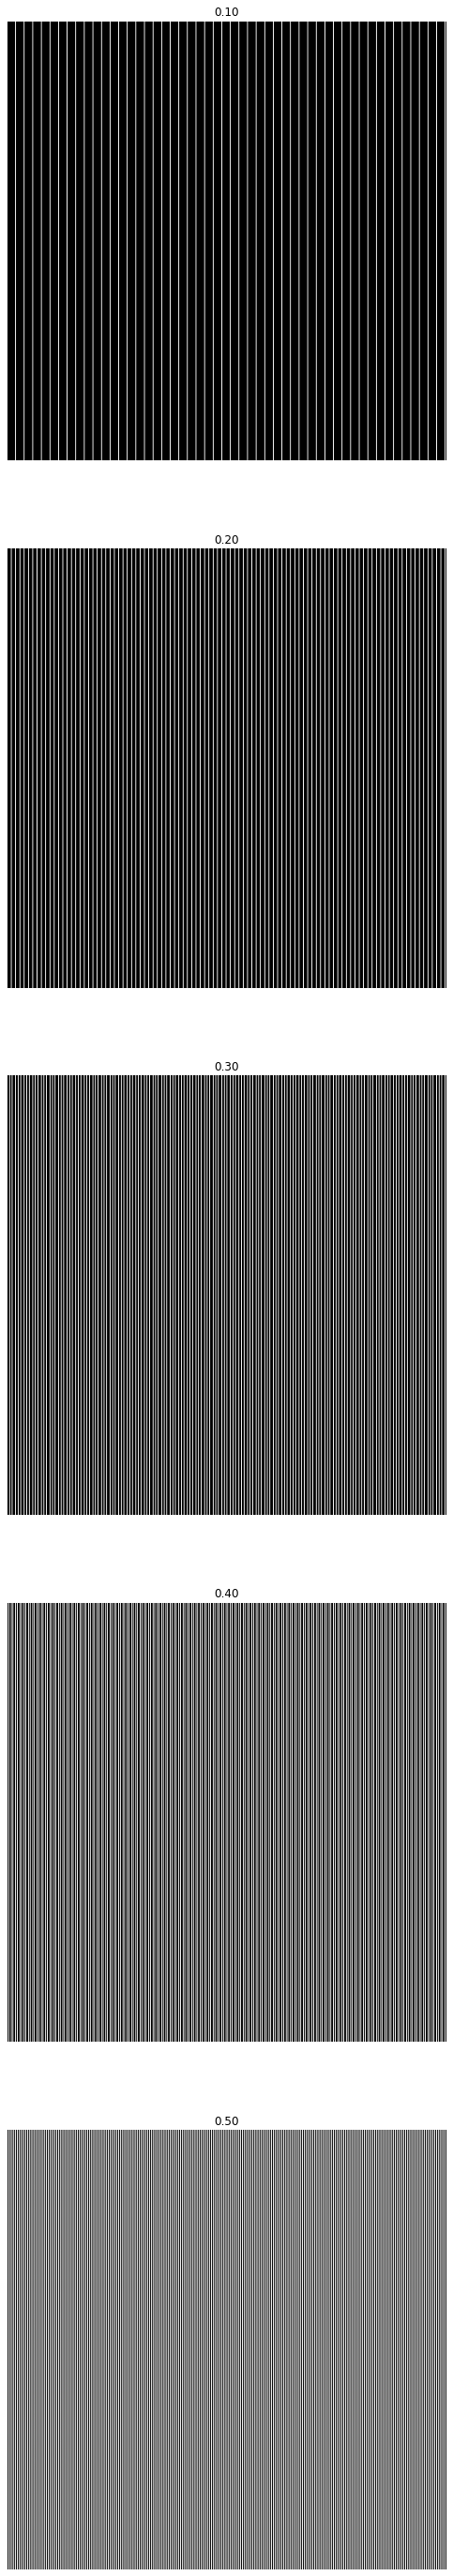

In [4]:
def sample_sino(sinogram, sample_rate):
    
    # get n samplings
    n_s = sinogram.shape[1]
    
    # get step size
    step_size = 1/sample_rate

    # get indices not being sampled
    indices = np.arange(0, n_s, step_size).astype(int)
    theta_inds = np.arange(0, n_s)
    zero_inds = list(set(theta_inds) - set(indices)) # indices to be set to 0
    
    # set non-sampled indices to 0
    sampled_sinogram = sinogram.copy()
    sampled_sinogram[:, zero_inds] = 0
    
    return sampled_sinogram, indices

sample_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
# sample_rates = [1/32, 1/16, 1/8, 1/4, 1/2]

sampled_sinograms = []
for sample_rate in sample_rates:
    dobj_sinogram = np.ones((512,512)) 
    sampled_sinogram, indices = sample_sino(dobj_sinogram, sample_rate)
    eff_sample_rate = len(indices)/dobj_sinogram.shape[1]
    print('target sample rate: {:.2f}, effective sample rate: {:.2f}'.format(sample_rate, eff_sample_rate))
    print(indices[:10])
    sampled_sinograms.append(sampled_sinogram)
    
fig, axs = plt.subplots(len(sample_rates), 1, figsize=(10, len(sample_rates)*10), squeeze=False)
for i, (sample_rate, sinogram) in enumerate(zip(sample_rates, sampled_sinograms)):

    # put dobj into the img
    axs[i,0].imshow(sinogram, cmap='gray')
    axs[i,0].set_title('{:.2f}'.format(sample_rate))
    axs[i,0].axis('off')
# plt.suptitle("Sample Rates")
plt.show()

In [38]:
562*562

315844

# Test sampling rates

In [22]:
### CREATE SINOGRAM

# options
dobj_value=5.16 # mag. of dense object implanted; 5.16 corresponds to steel
radius=20 # radiuas of artifact
spread=10 # max spread of artifact radius
# n_samples=max(raw_img.shape) # number of baseline samplings of image
n_samples = 512
circle=False # whether to take circle when taking transform

# put dobj into the img
poss_radii = np.arange(radius-spread,radius+spread+1)
dobj_radius =  np.random.choice(poss_radii, size=1)[0]
dobj = create_dobj(dobj_radius, irregular=False)
dobj_img = insert_dobj(raw_img.copy(), dobj, random_location=True, intensity=dobj_value)

# get sinogram of dobj img
theta = np.linspace(0., 180., n_samples, endpoint=False)
print('len of theta:',len(theta))
dobj_sinogram = radon(dobj_img, theta=theta, circle=circle)
print("dobj_sinogram shape:", dobj_sinogram.shape)

len of theta: 512
dobj_sinogram shape: (512, 512)


In [32]:
from skimage.transform import rescale, resize, iradon
theta = np.linspace(0., 180., 512, endpoint=False)
def _iradon_wrapper(sinogram_):
    #         print(sinogram_.shape, type(sinogram)
    #              )
    sinogram_ = sinogram_.reshape(512,512)
    return iradon(sinogram_, theta=theta, circle=False)
data = np.stack([dobj_sinogram, dobj_sinogram]).reshape(2, 512,512,1)
data = np.reshape(data, (2, 512*512))
trans = np.apply_along_axis(_iradon_wrapper, axis=(1), arr=data)
trans.shape

(2, 362, 362)

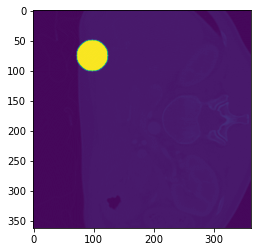

In [34]:
plt.imshow(trans[1])

In [37]:
512*512, np.sqrt(262088)

(262144, 511.9453095790604)

In [18]:
#### SAMPLING

    
# determine max sampling rate to be 362 angles
sample_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
max_n = 362
sampled_sinograms = []
for sample_rate in sample_rates:
    
    sampled_sinogram, indices = sample_sino(dobj_sinogram, sample_rate)
    eff_sample_rate = len(indices)/dobj_sinogram.shape[1]
    print('target sample rate: {:.2f}, effective sample rate: {:.2f}'.format(sample_rate, eff_sample_rate))
    sampled_sinograms.append(sampled_sinogram)

len of theta: 512
dobj_sinogram shape: (512, 512)
target sample rate: 0.10, effective sample rate: 0.10
target sample rate: 0.20, effective sample rate: 0.20
target sample rate: 0.30, effective sample rate: 0.30
target sample rate: 0.40, effective sample rate: 0.40
target sample rate: 0.50, effective sample rate: 0.50


# Plot sample rates

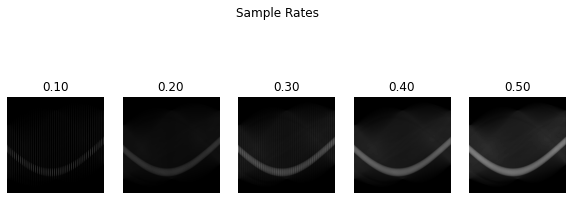

In [19]:
fig, axs = plt.subplots(1, len(sample_rates), figsize=(len(sample_rates)*2, 4), squeeze=False)
for i, (sample_rate, sinogram) in enumerate(zip(sample_rates, sampled_sinograms)):

    # put dobj into the img
    axs[0,i].imshow(sinogram, cmap='gray')
    axs[0,i].set_title('{:.2f}'.format(sample_rate))
    axs[0,i].axis('off')
plt.suptitle("Sample Rates")
plt.show()